In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as smapi
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
from math import sqrt
import itertools 


color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [348]:
url = 'https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv'

df = pd.read_csv(url)

#df = df.rename(columns={'Month' : 'date', '#Passengers' : 'passengers'})

#df = df.set_index('date')

#df.index = pd.to_datetime(df.index)

In [349]:
df['Date'] = pd.to_datetime(df['Month'])
df = df.drop(columns = 'Month')
df = df.set_index('Date')
df = df.rename(columns = {'#Passengers':'passengers'})
df.head()

,passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [350]:
###Supportive Functions for Time Series Analysis

In [351]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [352]:
def tsplot(y, lags=40, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [353]:
###Plot data

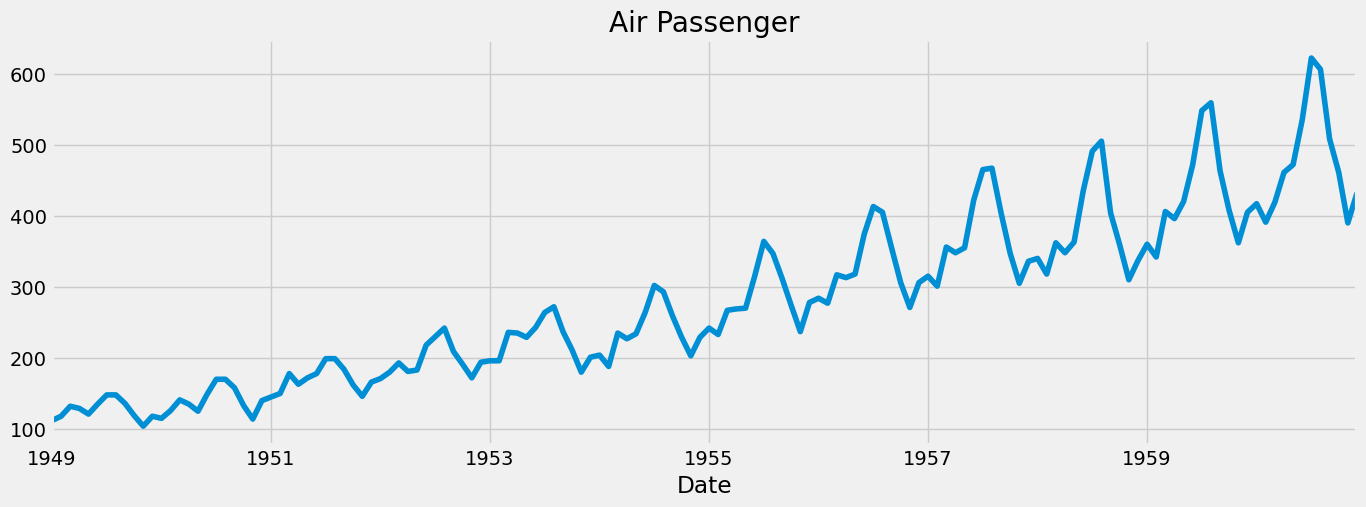

In [354]:
df['passengers'].plot(style='',
        figsize=(15, 5),
        color=color_pal[0],
        title='Air Passenger')
plt.show()

In [355]:
###log Transformation

#df_log=np.log(df['passengers'])

In [356]:
#df_log.plot(style='',
        #figsize=(15, 5),
        #color=color_pal[0],
        #title='Air Passenger')
#plt.show()

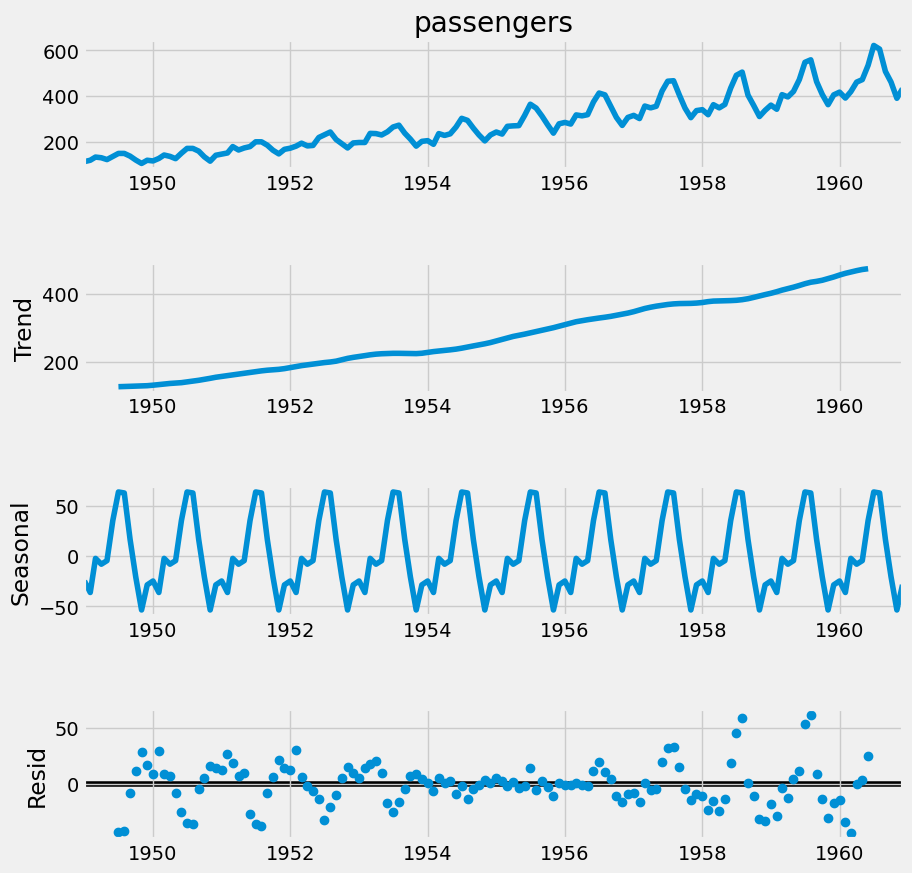

In [357]:
#decomposition
decomposition = sm.tsa.seasonal_decompose(df['passengers'], model = 'additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [358]:
df.isna().sum()

passengers    0
dtype: int64

In [359]:
###log Transformation

df_log=np.log(df['passengers'])

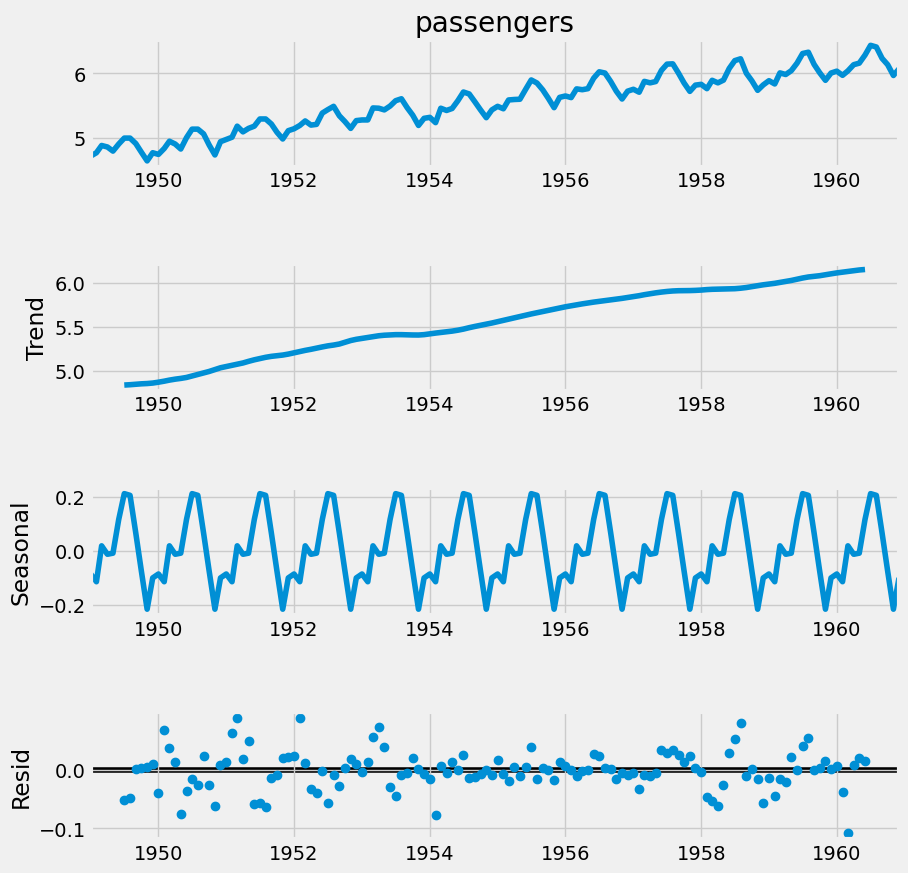

In [360]:
#decomposition
decomposition = sm.tsa.seasonal_decompose(df_log, model = 'additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [361]:
### Check Stationarity:Original data_log

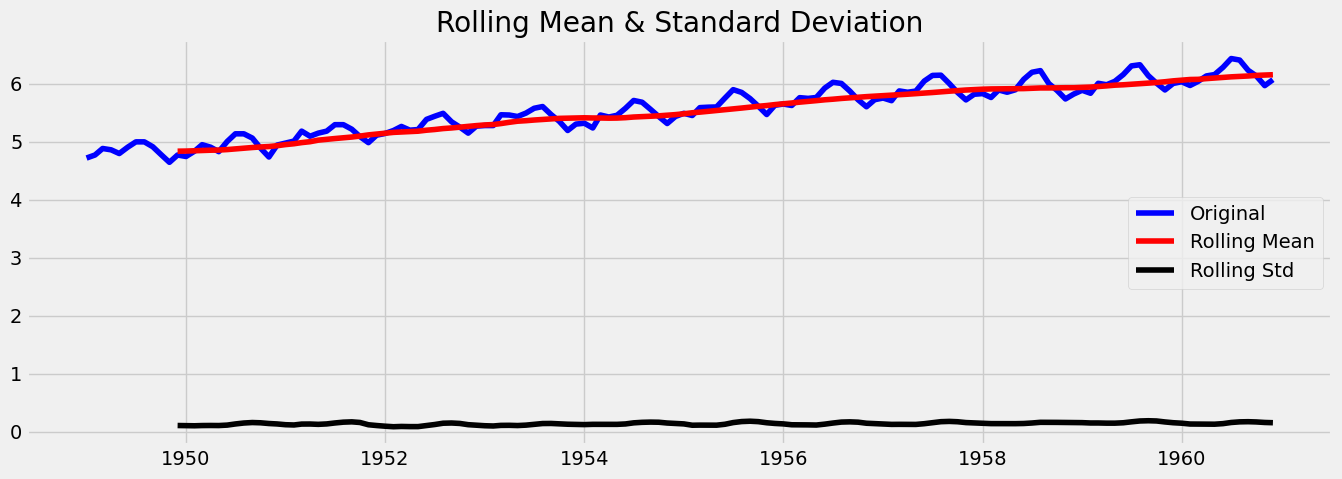

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [362]:
test_stationarity(df_log)

In [363]:
### Procedures for ARIMA model
  
    ## 1.Split dataset into Training and Test
  
    ## 2.Differencing : Training dataset
  
    ## 3.Check Stationarity : Differenced Training dataset
  
    ## 4.ACF,PACF plot 
  
    ## 5.Identification ARIMA model parameters
       # Fit Model
       # Forecast using Test dataset
   
   ## 6. Forecast in Sample
   ## 7. Forecast out of Sample

In [364]:
df_log= pd.DataFrame(df_log, columns=['passengers'])

In [365]:
df_log

,passengers
Date,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398


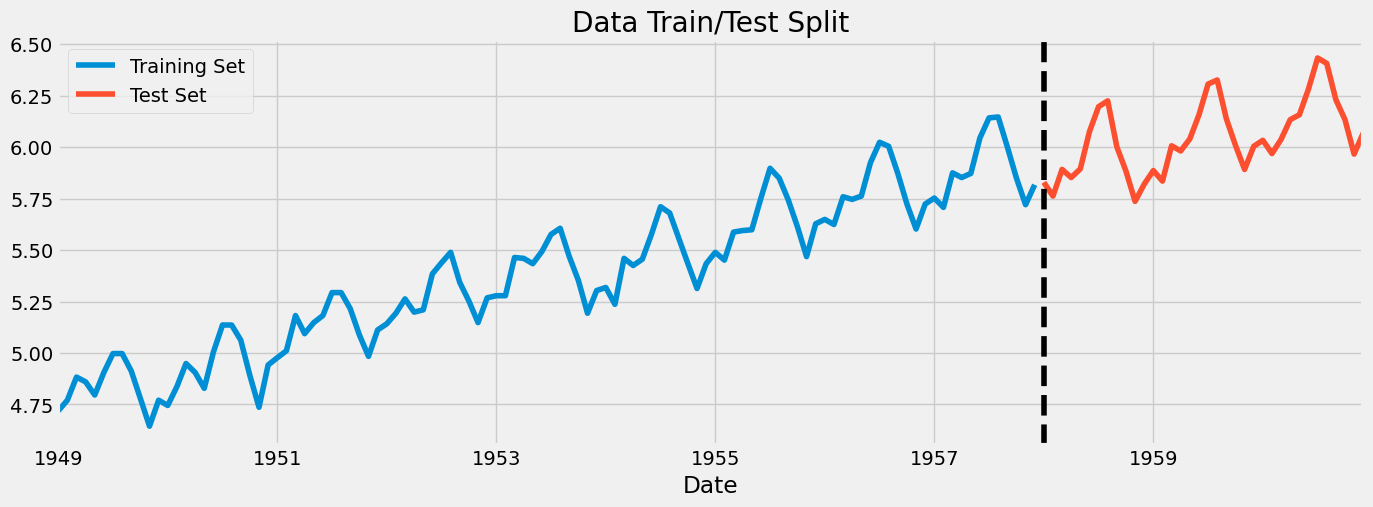

In [366]:
# 1.Split dataset into Training and Test

train = df_log['passengers'].loc[df_log['passengers'].index < '01-01-1958']
test = df_log['passengers'].loc[df_log['passengers'].index >= '01-01-1958']
test_exp=df['passengers'].loc[df['passengers'].index >= '01-01-1958']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-1958', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [367]:
# 2.Differencing : Training dataset

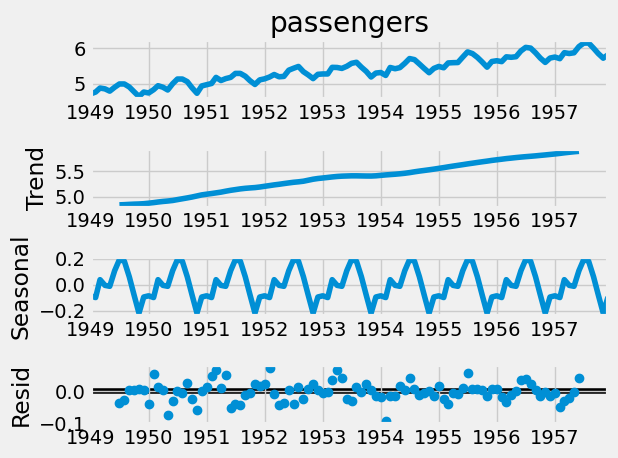

In [368]:
train_diff = train.diff()
train_diff = train_diff.dropna()

dec = sm.tsa.seasonal_decompose(train,period = 12).plot()
plt.show()


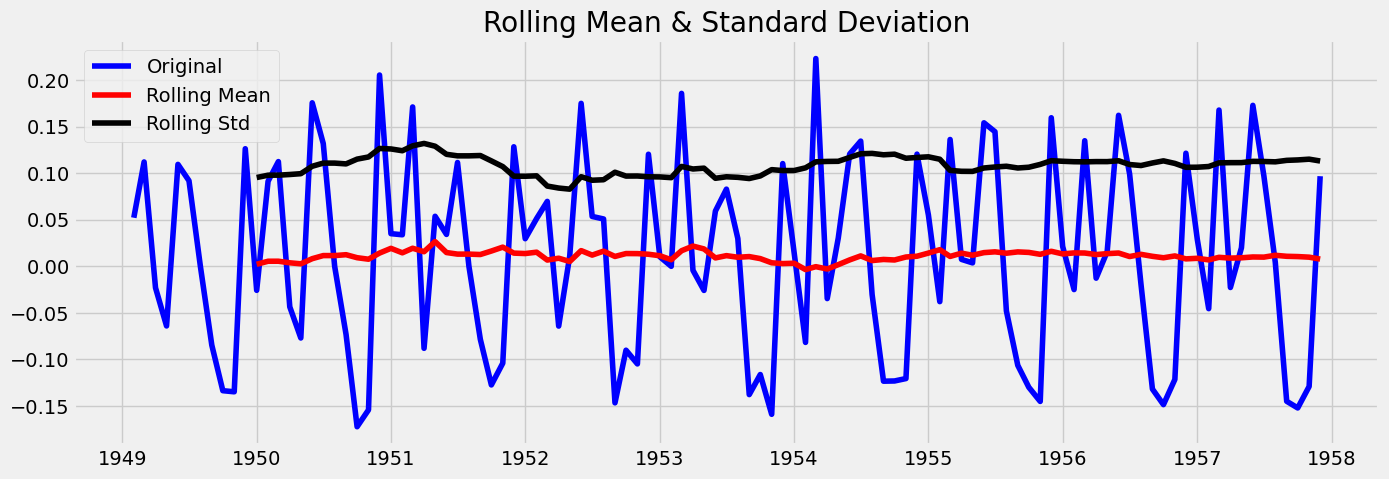

Results of Dickey-Fuller Test:
Test Statistic                 -2.860949
p-value                         0.050081
#Lags Used                     12.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [369]:
# 3.Check Stationarity : Differenced Training dataset

test_stationarity(train_diff)

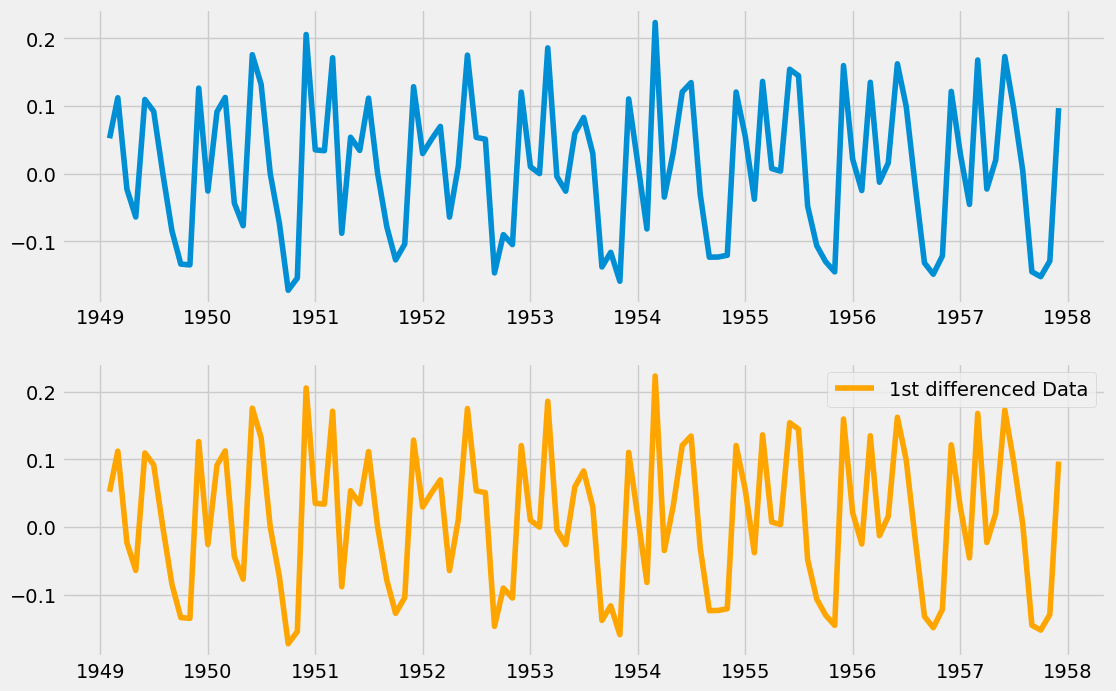

In [370]:
#Differenced data plot

plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_diff)
plt.subplot(212)
plt.plot(train_diff, 'orange')
plt.legend(['1st differenced Data'])
plt.show()

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


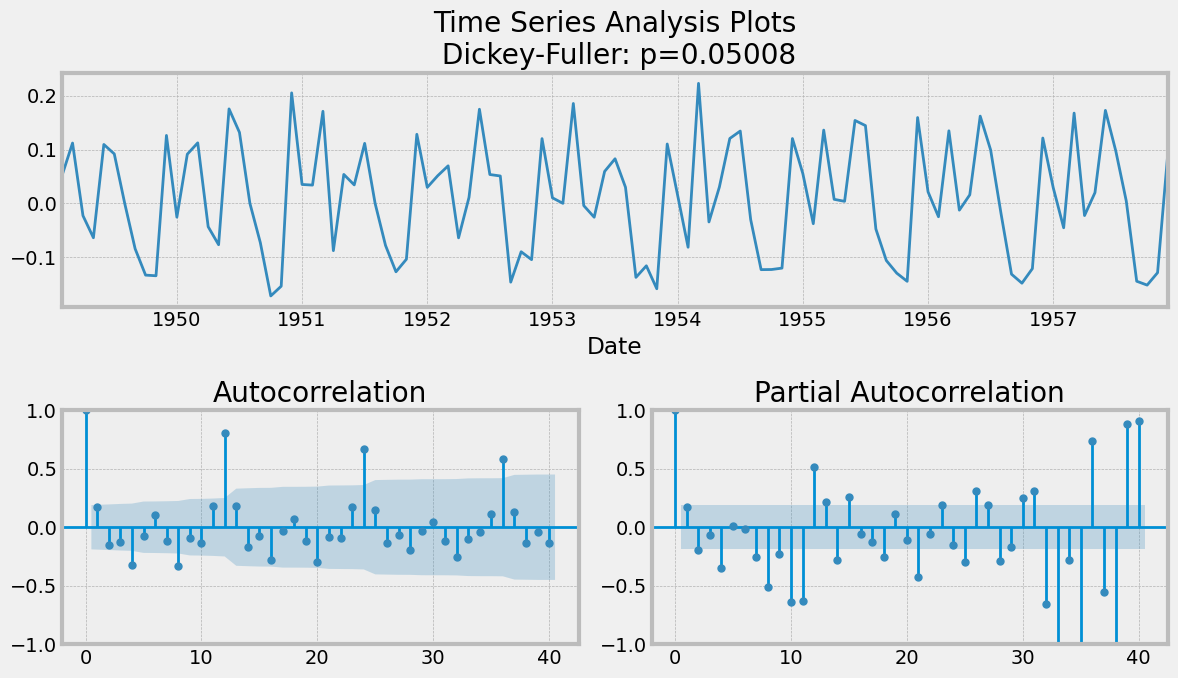

In [371]:
# 4.ACF,PACF plot 
tsplot(train_diff)

In [372]:
 ## 5.Identification ARIMA model parameters
       # Fit Model
       # Forecast using Test dataset

In [373]:
## it is uncertain when checked ACF and PACF. 
# Fit ARIMA Model
#model = ARIMA(train, order=(1,1,0))

#model_fit = model.fit()

#model_fit.summary()

In [374]:
# Search Parameters

print('Paramater combinations for ARIMA model')
p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))

aic = []

for i in pdq :
    model = ARIMA(train.values, order = (i))
    model_fit = model.fit()
    print(f'ARIMA : {i} >> AIC : {round(model_fit.aic, 2)}')
    aic.append(round(model_fit.aic,2))

Paramater combinations for ARIMA model
ARIMA : (0, 1, 0) >> AIC : -177.81
ARIMA : (0, 1, 1) >> AIC : -180.92
ARIMA : (0, 1, 2) >> AIC : -183.8
ARIMA : (1, 1, 0) >> AIC : -179.28
ARIMA : (1, 1, 1) >> AIC : -183.59
ARIMA : (1, 1, 2) >> AIC : -187.77
ARIMA : (2, 1, 0) >> AIC : -180.99
ARIMA : (2, 1, 1) >> AIC : -188.18
ARIMA : (2, 1, 2) >> AIC : -186.42


In [375]:
  ## Search Otimal Parameter

optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[((2, 1, 1), -188.18)]

In [376]:
model_opt = ARIMA(train.values, order = optimal[0][0])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  98.089
Date:                Sun, 05 Mar 2023   AIC                           -188.178
Time:                        09:39:36   BIC                           -177.487
Sample:                             0   HQIC                          -183.844
                                - 108                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9374      0.120      7.810      0.000       0.702       1.173
ar.L2         -0.3506      0.135     -2.591      0.010      -0.616      -0.085
ma.L1         -0.8107      0.131     -6.207      0.000      -1.067      -0.555
sigma2         0.0093      0.002      5.513      0.000       0.006       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 6.91
Prob(Q):                              0.44   Prob(JB):                         0.03
Heteroskedasticity (H):               1.04   Skew:                             0.30
Prob(H) (two-sided):                  0.91   Kurtosis:                         1.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [377]:
## 6. Forecast in Sample

In [401]:
print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

# Create lists to store original (actual) and predicted values
original_vals = []
predicted_vals = []

for t in range(len(test)):
    try:
        model_opt = ARIMA(history, order=(2,1,1))
        model_opt_fit = model_opt.fit()
        output = model_opt_fit.forecast()
     
        yhat = np.exp(output[0])
        
        # append the predicted value to the list
        predictions.append(yhat)
        
        # update the history variable with the actual observation value
        obs = test[t]
        history.append(obs)
        # Store the original and predicted values
        original_vals.append(np.exp(obs))
        predicted_vals.append(yhat)
       
        print('Predicted=%f, Expected=%f' % (yhat, np.exp(obs)))
    except Exception as e:
        # handle exceptions gracefully
        print('Error during processing: ', e)



	 ARIMA MODEL : In- Sample Forecasting 

Predicted=359.170854, Expected=340.000000
Predicted=347.214613, Expected=318.000000
Predicted=319.489955, Expected=362.000000
Predicted=377.415668, Expected=348.000000
Predicted=343.332036, Expected=363.000000
Predicted=365.266143, Expected=435.000000
Predicted=439.984544, Expected=491.000000
Predicted=474.655396, Expected=505.000000
Predicted=474.181965, Expected=404.000000
Predicted=367.434862, Expected=359.000000
Predicted=353.825884, Expected=310.000000
Predicted=312.607835, Expected=337.000000
Predicted=362.501278, Expected=360.000000
Predicted=374.093783, Expected=342.000000
Predicted=342.367482, Expected=406.000000
Predicted=422.584402, Expected=396.000000
Predicted=384.364195, Expected=420.000000
Predicted=416.152430, Expected=472.000000
Predicted=465.773204, Expected=548.000000
Predicted=532.485266, Expected=559.000000
Predicted=520.779804, Expected=463.000000
Predicted=421.007336, Expected=407.000000
Predicted=394.973574, Expected=362.

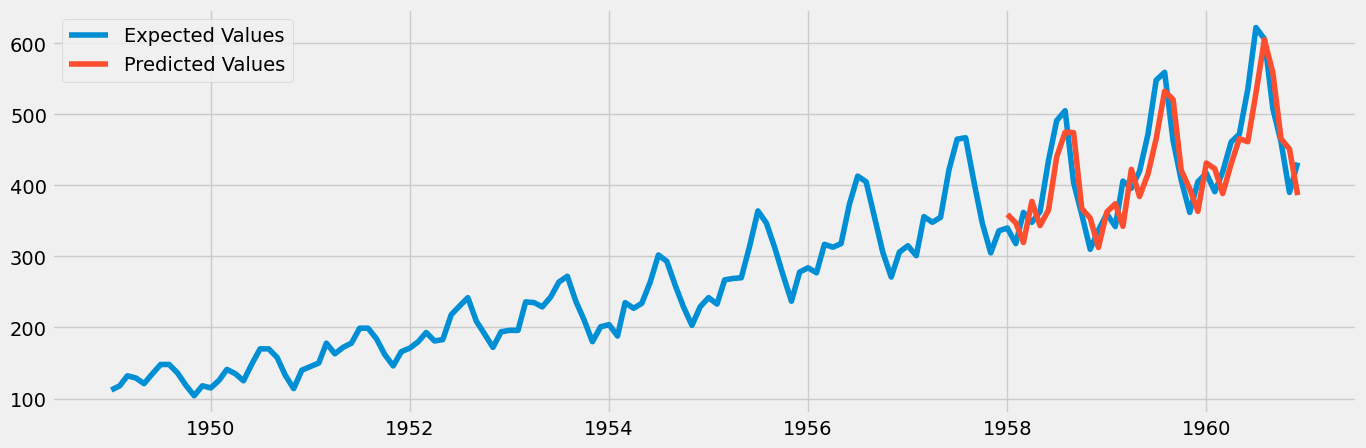

In [403]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(np.exp(df_log['passengers']),label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [404]:
error = np.sqrt(mean_squared_error(original_vals,predicted_vals))
print('Test RMSE: %.4f' % error)

Test RMSE: 43.9835


In [172]:
## 7. Forecast out of Sample

In [405]:
from pandas.tseries.offsets import DateOffset
future_dates = [df['passengers'].index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = df.columns)

forecast = pd.concat([df,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN


In [265]:
# Forecast Function 

In [406]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model_opt = ARIMA(ARIMA_history_f, order = (2,1,2))
    model_opt_fit =model_opt.fit()
    
    output = model_opt_fit.forecast()[0]
    
    ARIMA_history_f.append(output)
    
    f1.append(output)
   
for i in range(len(f1)):
    forecast.iloc[144 + i,1] =np.exp(f1[i])
forecast.tail()

,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,355.920461,NaN
1961-10-12,NaN,355.920460,NaN
1961-10-19,NaN,355.920460,NaN
1961-10-26,NaN,355.920459,NaN
1961-11-02,NaN,355.920459,NaN


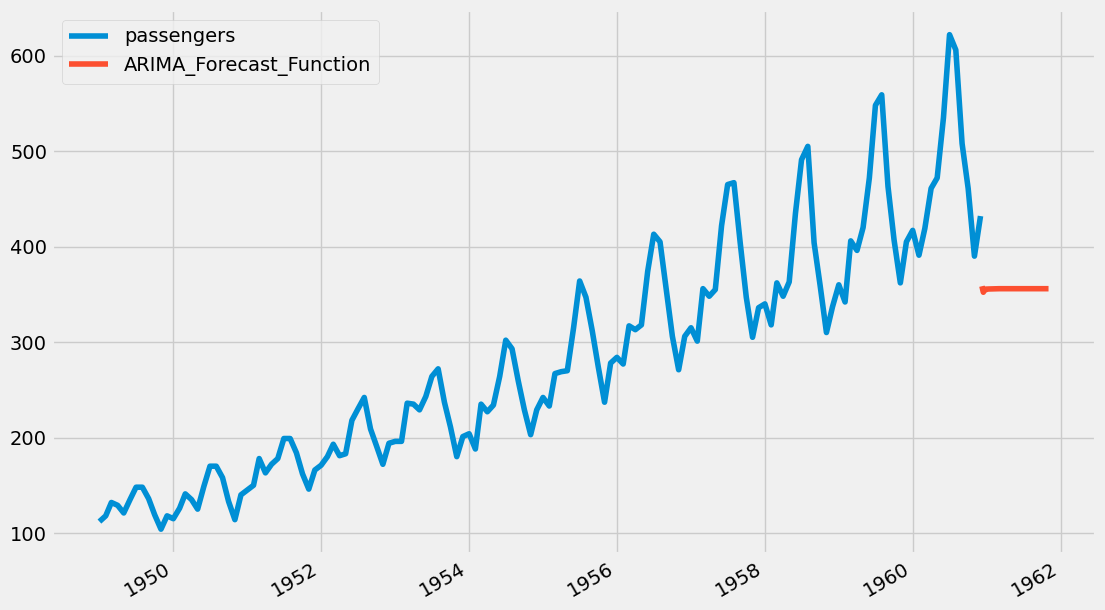

In [407]:
forecast[['passengers','ARIMA_Forecast_Function']].plot(figsize = (12,8));

In [ ]:
# Predict Function 

In [408]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit()
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[144 + i,2] = np.exp(f2[i])
forecast.tail()

,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function
1961-10-05,NaN,355.920461,355.920461
1961-10-12,NaN,355.920460,355.920460
1961-10-19,NaN,355.920460,355.920460
1961-10-26,NaN,355.920459,355.920459
1961-11-02,NaN,355.920459,355.920459


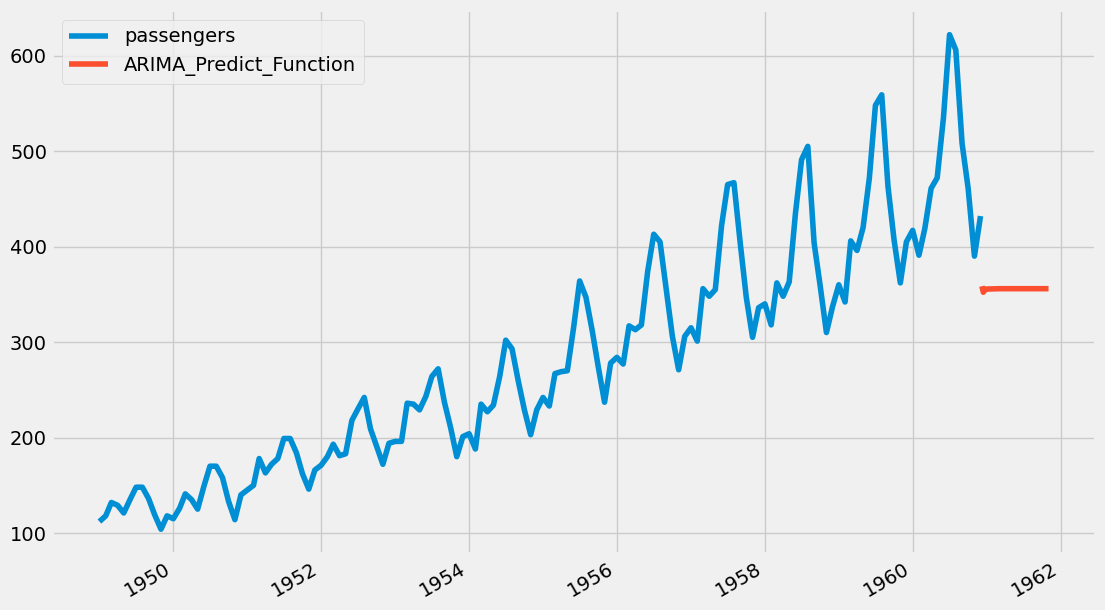

In [409]:
forecast[['passengers','ARIMA_Predict_Function']].plot(figsize = (12,8));

In [410]:
sum(f1) == sum(f2)

True

In [ ]:
## Forecast_test : SARIMA

In [411]:
 ###SARIMA
    ## Search parameter
    
print('Paramater combinations for SARIMA model')

p = range(0,3)
d = range(1,2)
q = range(0,3)

pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []

for i in pdq :
    for j in seasonal_pdq:
        try:
            sa_model = SARIMAX(train.values, order = (i), seasonal_order = (j))
            sa_model_fit =sa_model.fit()
            print(f'SARIMA : {i}{j} >> AIC : {round(model_fit.aic, 2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

Paramater combinations for SARIMA model
SARIMA : (0, 1, 0)(0, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(0, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 0)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(2, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 0)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(0, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 1)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(2, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 1)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 1)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(0, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(2, 1, 0, 12) >> AIC : -328.99
SARIMA : (0, 1, 2)(2, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (0, 1, 2)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(0, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(2, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 0)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(0, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(2, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 1)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 1)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(0, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(0, 1, 2, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(2, 1, 0, 12) >> AIC : -328.99
SARIMA : (1, 1, 2)(2, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (1, 1, 2)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(0, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 0)(0, 1, 1, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(2, 1, 0, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (2, 1, 0)(2, 1, 2, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(0, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(0, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 1)(1, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(1, 1, 1, 12) >> AIC : -328.99
SARIMA : (2, 1, 1)(1, 1, 2, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 1)(2, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 2)(0, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(0, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(0, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 2)(1, 1, 0, 12) >> AIC : -328.99
SARIMA : (2, 1, 2)(1, 1, 1, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(1, 1, 2, 12) >> AIC : -328.99
SARIMA : (2, 1, 2)(2, 1, 0, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA : (2, 1, 2)(2, 1, 1, 12) >> AIC : -328.99
SARIMA : (2, 1, 2)(2, 1, 2, 12) >> AIC : -328.99


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [413]:
##Search optimal parameter
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal 

[(((0, 1, 0), (0, 1, 0, 12)), -328.99),
 (((0, 1, 0), (0, 1, 1, 12)), -328.99),
 (((0, 1, 0), (0, 1, 2, 12)), -328.99),
 (((0, 1, 0), (1, 1, 0, 12)), -328.99),
 (((0, 1, 0), (1, 1, 1, 12)), -328.99),
 (((0, 1, 0), (1, 1, 2, 12)), -328.99),
 (((0, 1, 0), (2, 1, 0, 12)), -328.99),
 (((0, 1, 0), (2, 1, 1, 12)), -328.99),
 (((0, 1, 0), (2, 1, 2, 12)), -328.99),
 (((0, 1, 1), (0, 1, 0, 12)), -328.99),
 (((0, 1, 1), (0, 1, 1, 12)), -328.99),
 (((0, 1, 1), (0, 1, 2, 12)), -328.99),
 (((0, 1, 1), (1, 1, 0, 12)), -328.99),
 (((0, 1, 1), (1, 1, 1, 12)), -328.99),
 (((0, 1, 1), (1, 1, 2, 12)), -328.99),
 (((0, 1, 1), (2, 1, 0, 12)), -328.99),
 (((0, 1, 1), (2, 1, 1, 12)), -328.99),
 (((0, 1, 1), (2, 1, 2, 12)), -328.99),
 (((0, 1, 2), (0, 1, 0, 12)), -328.99),
 (((0, 1, 2), (0, 1, 1, 12)), -328.99),
 (((0, 1, 2), (0, 1, 2, 12)), -328.99),
 (((0, 1, 2), (1, 1, 0, 12)), -328.99),
 (((0, 1, 2), (1, 1, 1, 12)), -328.99),
 (((0, 1, 2), (1, 1, 2, 12)), -328.99),
 (((0, 1, 2), (2, 1, 0, 12)), -328.99),


In [414]:
sa_model_opt = SARIMAX(train.values, order = optimal[0][0][0], seasonal_order = optimal[0][0][1])
sa_model_opt_fit = sa_model_opt.fit()

sa_model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 154.709
Date:                            Sun, 05 Mar 2023   AIC                           -307.418
Time:                                    10:01:11   BIC                           -304.865
Sample:                                         0   HQIC                          -306.386
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0023      0.000      8.511      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                  11.13   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.00   Prob(JB):                         0.11
Heteroskedasticity (H):               0.13   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [419]:
print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
sa_predictions = []
sa_original_vals = []
sa_predicted_vals = []

for t in range(len(test)):
    try:
        sa_model_opt= sm.tsa.statespace.SARIMAX(history,order = (0, 1, 1),seasonal_order = (0, 1, 1, 12))
        sa_model_fit = sa_model_opt.fit()
    
        output = sa_model_fit.forecast()
        yhat = np.exp(output[0])
        
        sa_predictions.append(float(yhat))
        obs = test[t]     
        history.append(obs)
    
        sa_original_vals.append(np.exp(obs))
        sa_predicted_vals.append(yhat)
    
        print('predicted = %f, expected = %f' % (yhat, np.exp(obs)))
    
    except Exception as e:
        # handle exceptions gracefully
        print('Error during processing: ', e)

# calculate and print RMSE
rmse = math.sqrt(mean_squared_error(sa_original_vals, sa_predicted_vals))
print('RMSE:', rmse)


	 SARIMA MODEL : In - Sample Forecasting 



C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 350.657365, expected = 340.000000


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 332.663674, expected = 318.000000
predicted = 377.932496, expected = 362.000000


C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 360.418415, expected = 348.000000
predicted = 356.698476, expected = 363.000000
predicted = 421.523521, expected = 435.000000
predicted = 478.710705, expected = 491.000000
predicted = 482.448150, expected = 505.000000
predicted = 436.217879, expected = 404.000000
predicted = 359.421350, expected = 359.000000
predicted = 315.592171, expected = 310.000000
predicted = 350.201736, expected = 337.000000
predicted = 348.587751, expected = 360.000000
predicted = 338.701285, expected = 342.000000
predicted = 393.974026, expected = 406.000000
predicted = 390.871979, expected = 396.000000
predicted = 404.917835, expected = 420.000000
predicted = 490.569668, expected = 472.000000
predicted = 535.094354, expected = 548.000000
predicted = 547.338293, expected = 559.000000
predicted = 466.913202, expected = 463.000000
predicted = 407.017385, expected = 407.000000
predicted = 354.871481, expected = 362.000000
predicted = 397.937747, expected = 405.000000
predicted = 419.323585, expected =

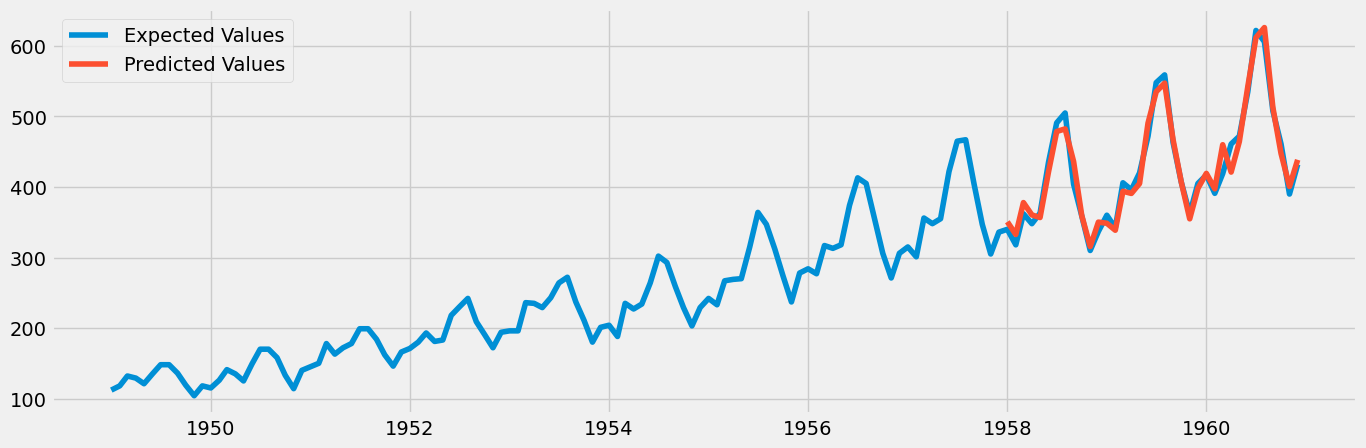

In [421]:
predictions_series = pd.Series(sa_predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(np.exp(df_log['passengers']),label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [422]:
# Out - of - Sample Forecasting: SARIMA
forecast['SARIMA_Forecast_Function'] = np.NaN
forecast['SARIMA_Predict_Function'] = np.NaN
forecast.head()

,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1949-01-01,112,NaN,NaN,NaN,NaN
1949-02-01,118,NaN,NaN,NaN,NaN
1949-03-01,132,NaN,NaN,NaN,NaN
1949-04-01,129,NaN,NaN,NaN,NaN
1949-05-01,121,NaN,NaN,NaN,NaN


In [423]:
# Forecast Function : SARIMA
SARIMA_history_f = [x for x in train]
f3 = []

for t in (range(len(df1))):
    
    sa_model = sm.tsa.statespace.SARIMAX(SARIMA_history_f,order = (0, 1, 1),seasonal_order = (0, 1, 1, 12))
    sa_model_fit = sa_model.fit()
    
    output = sa_model_fit.forecast()[0]
    
    SARIMA_history_f.append(output)
    f3.append(output)
    
for i in range(len(f3)):
    forecast.iloc[144 + i,3] = np.exp(f3[i])
forecast.tail()

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,355.920461,355.920461,724.507758,NaN
1961-10-12,NaN,355.920460,355.920460,635.634263,NaN
1961-10-19,NaN,355.920460,355.920460,552.003365,NaN
1961-10-26,NaN,355.920459,355.920459,484.966320,NaN
1961-11-02,NaN,355.920459,355.920459,545.683470,NaN


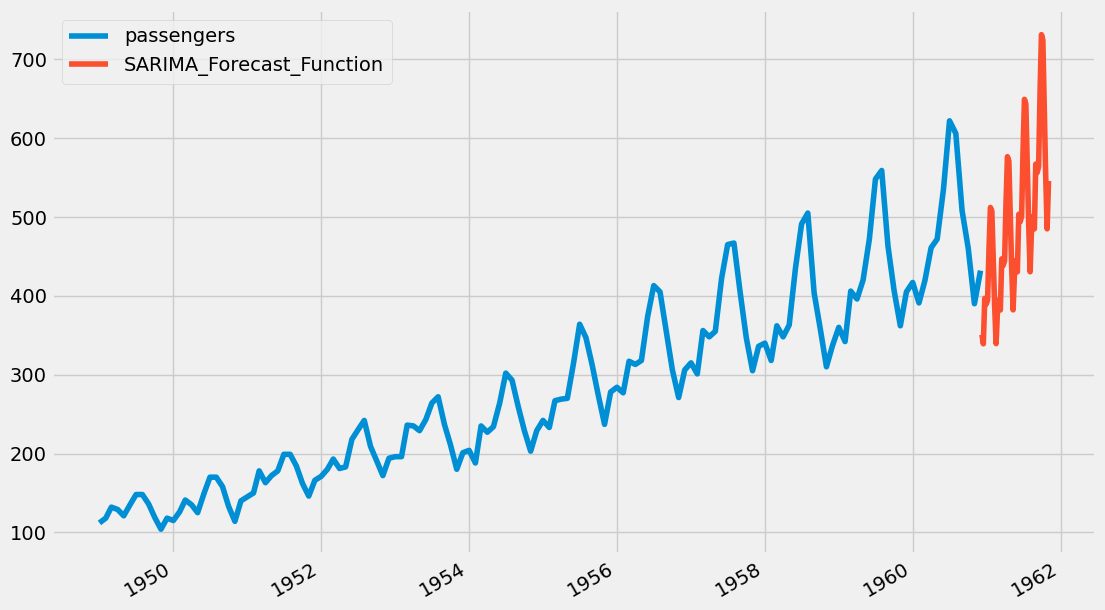

In [271]:
forecast[['passengers','SARIMA_Forecast_Function']].plot(figsize = (12,8));

In [424]:
# Predict Function: SARIMA
SARIMA_history_p = [x for x in train]
f4 = []

for t in range(len(df1)):
    
    sa_model = sm.tsa.statespace.SARIMAX(SARIMA_history_p,order = (2,1,2),seasonal_order = (0,1,1,12))
    sa_model_fit = sa_model.fit()
    
    output = sa_model_fit.predict(start = len(SARIMA_history_p),end = len(SARIMA_history_p),typ = 'levels')[0]
    
    SARIMA_history_p.append(output)
    f4.append(output)
    
for i in range(len(f4)):
    forecast.iloc[144 + i,4] = np.exp(f4[i])
forecast.tail()

C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\jongb\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

,passengers,ARIMA_Forecast_Function,ARIMA_Predict_Function,SARIMA_Forecast_Function,SARIMA_Predict_Function
1961-10-05,NaN,355.920461,355.920461,724.507758,741.081042
1961-10-12,NaN,355.920460,355.920460,635.634263,650.728085
1961-10-19,NaN,355.920460,355.920460,552.003365,565.574755
1961-10-26,NaN,355.920459,355.920459,484.966320,496.870973
1961-11-02,NaN,355.920459,355.920459,545.683470,559.668100


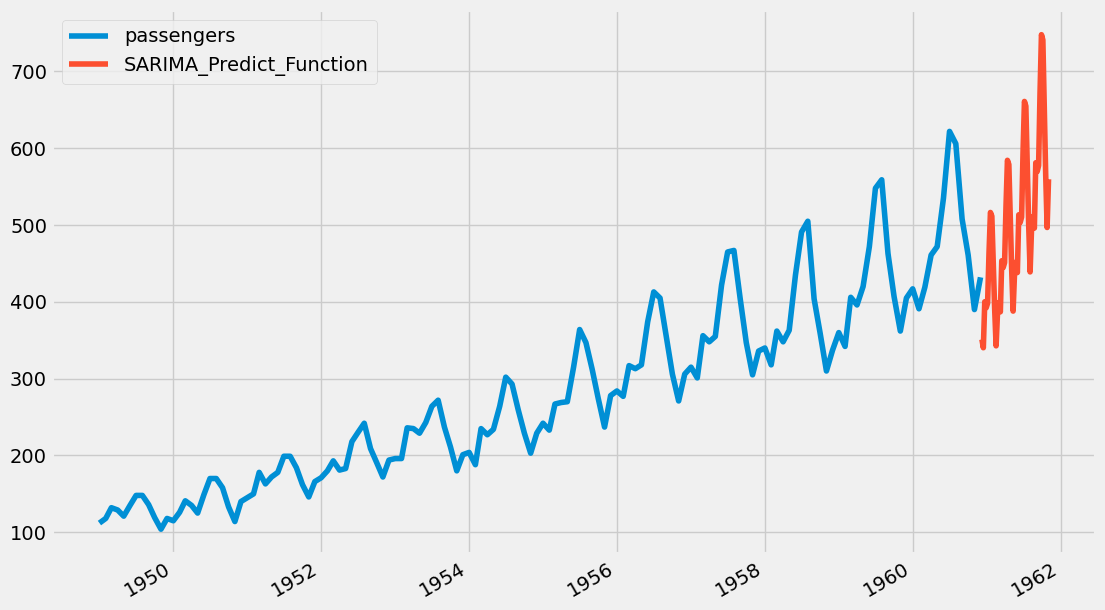

In [425]:
forecast[['passengers','SARIMA_Predict_Function']].plot(figsize = (12,8));

In [426]:
sum(f3) == sum(f4)

False

In [427]:
## Auto ARIMA
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

In [428]:
auto_arima_model  = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=12, d=1,seasonal=True, 
                      start_P=0, start_Q=0, 
                      D=1, max_P=3, max_Q=3,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(auto_arima_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-316.280, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-307.418, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-336.580, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-344.586, Time=0.49 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-317.948, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-342.742, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-342.762, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-338.358, Time=0.15 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-340.703, Time=0.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-335.022, Time=0.16 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-343.299, Time=0.50 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-342.852, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-343.512, Time=0.27 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-340.587, Time=0.40 sec
 ARIMA(0,1,1)(0,1,1

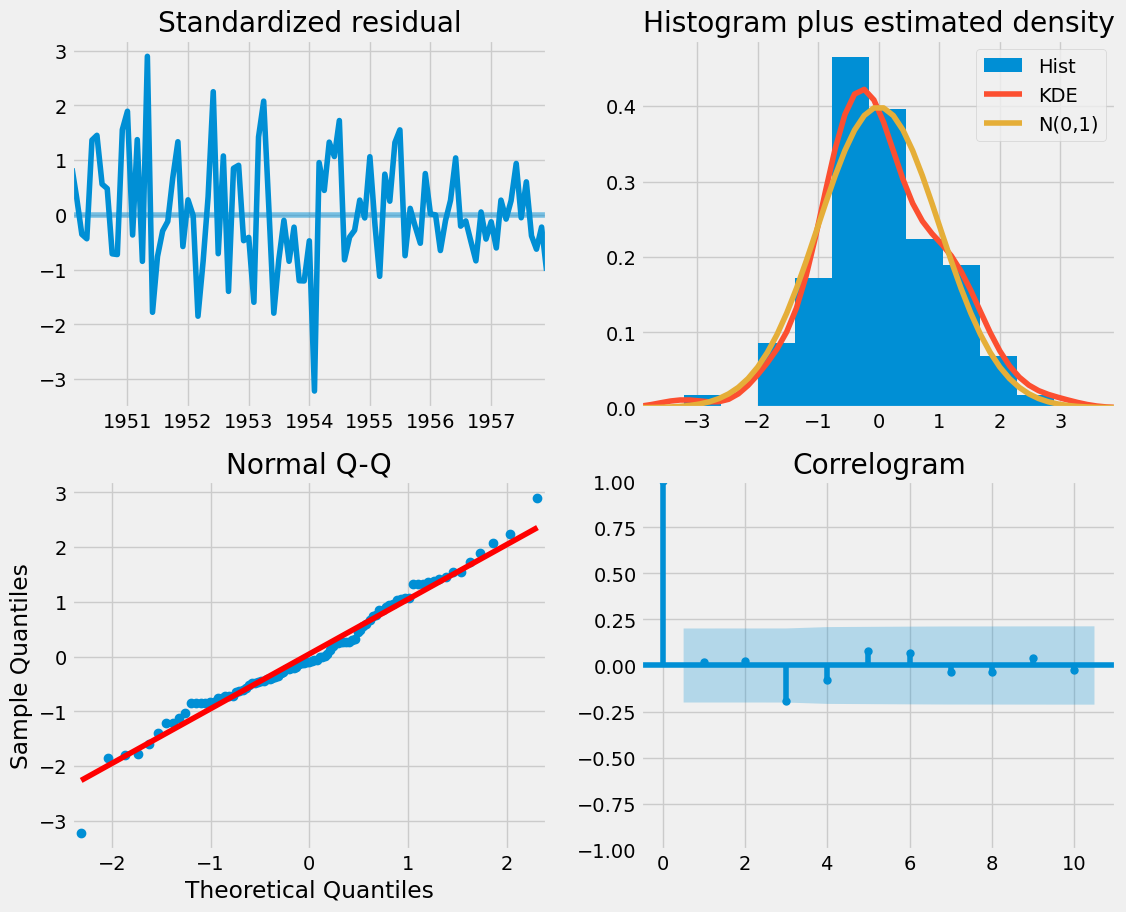

In [429]:
auto_arima_model.plot_diagnostics(figsize=(12,10))
plt.show()

In [430]:
# Forecast

prediction, confint = auto_arima_model.predict(n_periods=len(test), return_conf_int=True)

prediction=np.exp(prediction)
confint=np.exp(confint)

In [431]:
cf= pd.DataFrame(confint)

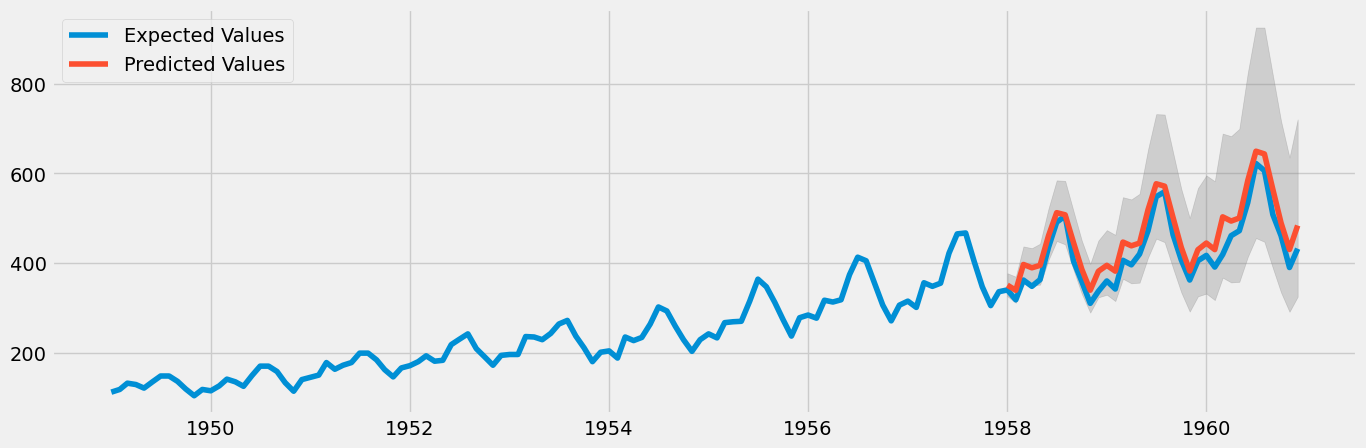

In [432]:
prediction_series = pd.Series(prediction, index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(np.exp(df_log['passengers']),label = 'Expected Values')
ax.plot(prediction_series,label = 'Predicted Values');
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1], color='grey', alpha=.3)
plt.legend(loc="upper left")
plt.show()
